## Purpose

This notebook computes 2023 daily accumulated precipitation and growing degree days throughout the contiguous United States with xarray and Dask.  Accumulated precipitation quantifies the total precipitation recieved over a period of time at a location.  Accumulated growing degree days quantifies the total amount of heat recieved over a period of time at a location.  These variables are important because, among other things, they effect crop growth and yield.

In [1]:
from urllib.request import urlretrieve 
import os

import xarray as xr
import numpy as np
from dask.distributed import Client

DATA_DIR = "/home/ubuntu/data"
RAW_DIR = f"{DATA_DIR}/raw"
ACC_DIR = f"{DATA_DIR}/acc"

In [2]:
# Utility functions

def plot_arr(arr, time):
    arr.sel(time=time).plot(x='lon', y='lat', robust=True)

def mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)

### Download Data
Download 2023 daily gridded total precipitation and minimum, maximum, and average temperature for the contiguous United States from the NOAA National Centers for Environmental Information.  See https://www.ncei.noaa.gov/products/land-based-station/nclimgrid-daily for more detail.  This data is in NetCDF format and will be written to the volume mounted to this machine.  This volume is also mounted to the Dask Scheduler and Dask Worker nodes. 

In [3]:
mkdir(RAW_DIR)

urls = ["https://www.ncei.noaa.gov/data/nclimgrid-daily/access/grids/2023/ncdd-2023{:0>2}-grd-scaled.nc".format(i) for i in range(1,13)]
for url in urls:
    filename = os.path.basename(url)
    out_path = f'{RAW_DIR}/{filename}'
    if os.path.exists(out_path):
        print(f"{out_path} exists! Skipping download...")
    else:
        urlretrieve(url, out_path)
        print(f"Downloaded to {out_path}")

Downloaded to /home/ubuntu/data/raw/ncdd-202301-grd-scaled.nc
Downloaded to /home/ubuntu/data/raw/ncdd-202302-grd-scaled.nc
Downloaded to /home/ubuntu/data/raw/ncdd-202303-grd-scaled.nc
Downloaded to /home/ubuntu/data/raw/ncdd-202304-grd-scaled.nc
Downloaded to /home/ubuntu/data/raw/ncdd-202305-grd-scaled.nc
Downloaded to /home/ubuntu/data/raw/ncdd-202306-grd-scaled.nc
Downloaded to /home/ubuntu/data/raw/ncdd-202307-grd-scaled.nc
Downloaded to /home/ubuntu/data/raw/ncdd-202308-grd-scaled.nc
Downloaded to /home/ubuntu/data/raw/ncdd-202309-grd-scaled.nc
Downloaded to /home/ubuntu/data/raw/ncdd-202310-grd-scaled.nc
Downloaded to /home/ubuntu/data/raw/ncdd-202311-grd-scaled.nc
Downloaded to /home/ubuntu/data/raw/ncdd-202312-grd-scaled.nc


### Initialize Dask Client
The client provides a connection to the Dask Scheduler and is used to submit the task graph to the Dask Scheduler that then submits tasks to the various Dask Workers.  The Dask dashboard allows us to monitor submitted tasks and can be viewed at http://localhost:8787/tasks.

In [4]:
client = Client("scheduler:8786")
client

<Client: 'tcp://172.22.0.5:8786' processes=3 threads=9, memory=11.18 GiB>

### xarray.DataSet
Create an xarray.DataSet instance from the downloaded NetCDF files.  This DataSet incudes four variables (i.e., tmax, tmin, prcp, and tavg) recorded for each day of 2023 throughout the contigous United States.  Each variable is an xarray.DataArray instance.  Each daily record for each variable has a shape of (596, 1385).  Further, each variable is chunked into a shape of (1, 298, 693) which means that one chunk represents a (298, 693) slice from a single day.

In [5]:
ds = xr.open_mfdataset("/home/ubuntu/data/raw/*nc", parallel=True)
ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 596, lon: 1385)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-12-31
  * lat      (lat) float32 24.56 24.6 24.65 24.69 ... 49.23 49.27 49.31 49.35
  * lon      (lon) float32 -124.7 -124.6 -124.6 -124.6 ... -67.1 -67.06 -67.02
Data variables:
    tmax     (time, lat, lon) float64 dask.array<chunksize=(1, 298, 693), meta=np.ndarray>
    tmin     (time, lat, lon) float64 dask.array<chunksize=(1, 298, 693), meta=np.ndarray>
    prcp     (time, lat, lon) float64 dask.array<chunksize=(1, 298, 693), meta=np.ndarray>
    tavg     (time, lat, lon) float64 dask.array<chunksize=(1, 298, 693), meta=np.ndarray>
Attributes: (12/33)
    date_created:               2023-04-05 02:52:17.522134
    date_modified:              2023-04-05 02:52:17.522481
    Conventions:                CF-1.7, ACDD-1.3
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    title:                      nClimGrid-Daily, Gridded Fields
    source:                     GHCN-Daily, nClimGrid-Monthly
    ...                         ...
    time_coverage_start:        2023-01-01
    time_coverage_end:          2023-01-31
    program:                    Center for Weather and Climate/Climate Scienc...
    geospatial_lat_resolution:  0.04167 degrees
    geospatial_lon_resolution:  0.04167 degrees
    platform:                   station

### Visualize xarry.DataArray
Plots are used to visualize a DataArray instance.  Here, indexing is used to select a single time from the precipitation DataArray.  The plot below shows the spatial variability of precipitation in the contiguous United States on July 20, 2023.

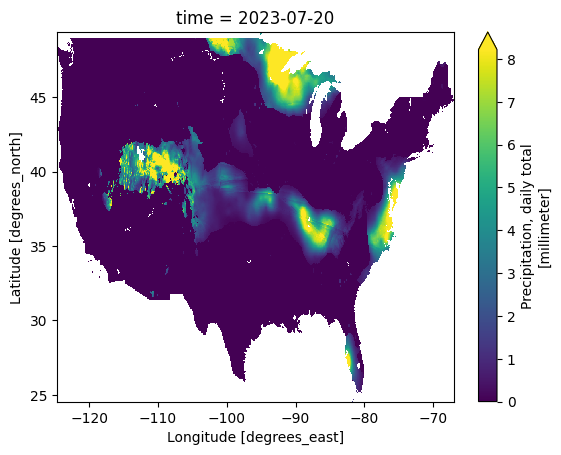

In [6]:
plot_arr(ds['prcp'], '2023-07-20')

### Compute Growing Degree Days

Growing degree days are computed daily using Method 2 described in McMaster & Wilhelm (1997).  Here, growing degree days are computed for corn which has a minimum base temperature of 10°C and a maximum base temperature of 30°C.  Output from a single day are shown in the graph below.

In [7]:
def apply_gdd(ds, lower, upper):
    return calc_gdd(ds['tmin'], ds['tmax'], lower, upper)
    
def calc_gdd(tmin, tmax, lower, upper):
    f_tmin = xr.where(tmin < lower, lower, tmin)
    f_tmax = xr.where(tmax > upper, upper, tmax) 
    gdd = ((f_tmax + f_tmin) / 2) - lower
    return xr.where(gdd < 0, 0, gdd)

gdd = ds.groupby("time.day").apply(apply_gdd, lower=10, upper=30)
gdd.attrs['long_name'] = 'Growing Degree Days'
gdd.attrs['units'] = ds['tmin'].attrs['units']
gdd

<xarray.DataArray (time: 365, lat: 596, lon: 1385)>
dask.array<getitem, shape=(365, 596, 1385), dtype=float64, chunksize=(1, 298, 693), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-12-31
  * lat      (lat) float32 24.56 24.6 24.65 24.69 ... 49.23 49.27 49.31 49.35
  * lon      (lon) float32 -124.7 -124.6 -124.6 -124.6 ... -67.1 -67.06 -67.02
Attributes:
    long_name:  Growing Degree Days
    units:      degree_Celsius

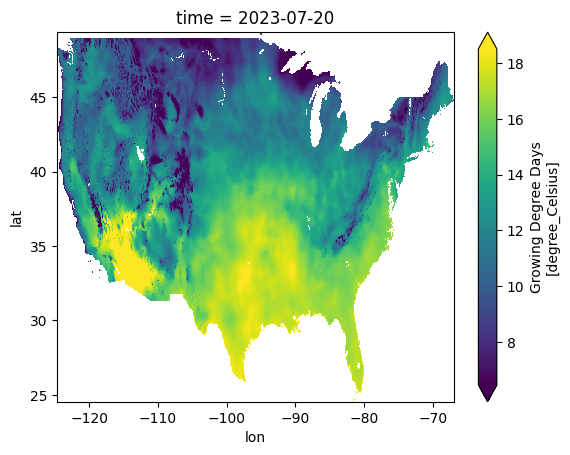

In [8]:
plot_arr(gdd, '2023-07-20')

### DataArray.cumsum
Accumulated growing degree days and precipitation are computed for each day in 2023 using the the DataArray.cumsum method.  Output for accumulated precipitation and growing degree days from a single day are shown in the graphs below.   

In [9]:
acc_gdd = gdd.cumsum(dim='time', skipna=False)
acc_gdd.name = 'acc_gdd'
acc_gdd.attrs['long_name'] = 'Accumulated Growing Degree Days'
acc_gdd.attrs['units'] = gdd.attrs['units']

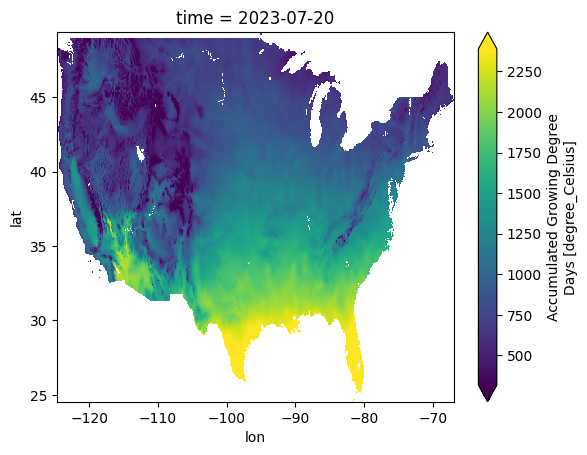

In [10]:
plot_arr(acc_gdd, '2023-07-20')

In [11]:
acc_prcp = ds['prcp'].cumsum(dim='time', skipna=False)
acc_prcp.name = 'acc_prcp'
acc_prcp.attrs['long_name'] = 'Accumulated Precipitation'
acc_prcp.attrs['unit'] = ds['prcp'].attrs['units']

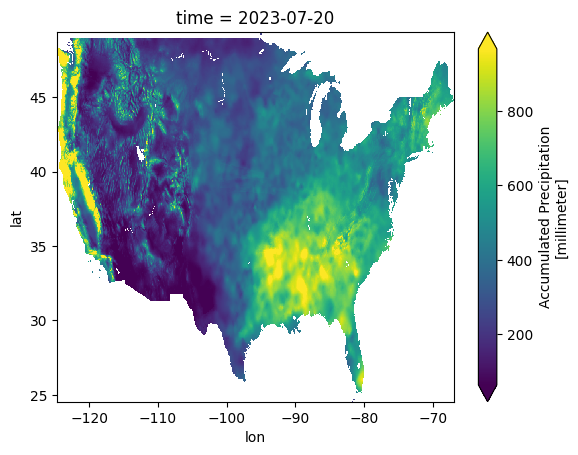

In [12]:
plot_arr(acc_prcp, '2023-07-20')

### Write Results
It is important to write intermediate results to disks to avoid running out of memory and to improve the performance of dowstream processing.  Here, we will write the daily accumulated precipitation and growing degree days data by month as NetCDF files to the attached volume.

In [13]:
def write_netcdf(ds, month):
    zero_pad_month = str(month).zfill(2)
    path = f"{ACC_DIR}/ncdd_acc-2023{zero_pad_month}-grd-scaled.nc"
    if os.path.exists(path):
        print(f'{path} exists! Skipping...')
    else:
        ds.to_netcdf(path)
        print(f"{path} write complete!")

mkdir(ACC_DIR)
acc_ds = xr.merge([acc_prcp, acc_gdd])
for month, acc_var in acc_ds.groupby('time.month'):
    write_netcdf(acc_var, month)

/home/ubuntu/data/acc/ncdd_acc-202301-grd-scaled.nc write complete!
/home/ubuntu/data/acc/ncdd_acc-202302-grd-scaled.nc write complete!
/home/ubuntu/data/acc/ncdd_acc-202303-grd-scaled.nc write complete!
/home/ubuntu/data/acc/ncdd_acc-202304-grd-scaled.nc write complete!
/home/ubuntu/data/acc/ncdd_acc-202305-grd-scaled.nc write complete!
/home/ubuntu/data/acc/ncdd_acc-202306-grd-scaled.nc write complete!
/home/ubuntu/data/acc/ncdd_acc-202307-grd-scaled.nc write complete!
/home/ubuntu/data/acc/ncdd_acc-202308-grd-scaled.nc write complete!
/home/ubuntu/data/acc/ncdd_acc-202309-grd-scaled.nc write complete!
/home/ubuntu/data/acc/ncdd_acc-202310-grd-scaled.nc write complete!
/home/ubuntu/data/acc/ncdd_acc-202311-grd-scaled.nc write complete!
/home/ubuntu/data/acc/ncdd_acc-202312-grd-scaled.nc write complete!


### Extract Data from a Single Location
Let's say, for instance, a grower wants to know the accumulated precipitation and growing degree days for one of their fields throughout 2023.  With the generated dataset, we can extract this information from a single location and visualize these metrics over time.  First, let's open the dataset.

In [14]:
acc_ds = xr.open_mfdataset("/home/ubuntu/data/acc/*nc", parallel=True)
acc_ds

<xarray.Dataset>
Dimensions:   (time: 365, lat: 596, lon: 1385)
Coordinates:
  * time      (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-12-31
  * lat       (lat) float32 24.56 24.6 24.65 24.69 ... 49.23 49.27 49.31 49.35
  * lon       (lon) float32 -124.7 -124.6 -124.6 -124.6 ... -67.1 -67.06 -67.02
Data variables:
    acc_prcp  (time, lat, lon) float64 dask.array<chunksize=(31, 596, 1385), meta=np.ndarray>
    acc_gdd   (time, lat, lon) float64 dask.array<chunksize=(31, 596, 1385), meta=np.ndarray>
Attributes:
    long_name:  Accumulated Precipitation
    unit:       millimeter

### Index DataSet and Convert to pandas.DataFrame
xarray allows for indexing a dataset by any of its dimensions.  Considering that this dataset has x and y dimensions corresponding to longitude and latitude, we can use coordinates of this grower's field to extract information from this DataSet.  Further, we can convert this information into a pandas.DataFrame and use the DataFrame.plot method to plot accumulated precipitation and growing degree days over time.

In [15]:
def pt_df(ds, lon, lat):
    return acc_ds.sel(lon=lon, lat=lat, method='nearest').to_dataframe()

lon = -88.9588891
lat = 38.0310683
df = pt_df(acc_ds, lon, lat)
df

,lat,lon,acc_prcp,acc_gdd
time,,,,
2023-01-01,38.020832,-88.979164,0.000000,0.539062
2023-01-02,38.020832,-88.979164,0.000000,3.039062
2023-01-03,38.020832,-88.979164,31.210938,7.566406
2023-01-04,38.020832,-88.979164,31.210938,11.800781
2023-01-05,38.020832,-88.979164,31.210938,11.800781
...,...,...,...,...
2023-12-27,38.020832,-88.979164,909.539062,2517.984375
2023-12-28,38.020832,-88.979164,911.289062,2517.984375
2023-12-29,38.020832,-88.979164,912.539062,2517.984375


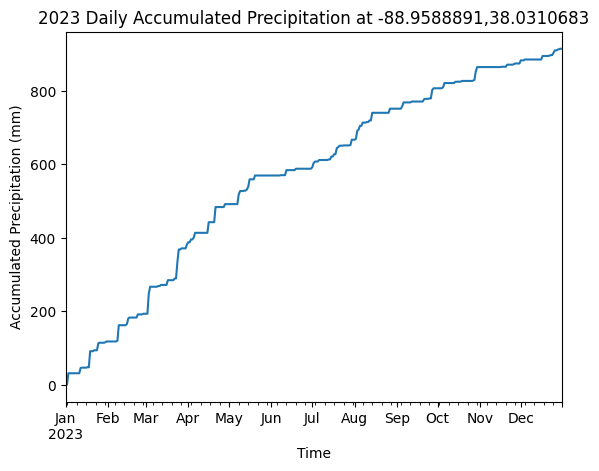

In [16]:
def plot_var(var_s, title, y_title):
    ax = var_s.plot()
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel(y_title)

plot_var(df['acc_prcp'], f'2023 Daily Accumulated Precipitation at {lon},{lat}', 'Accumulated Precipitation (mm)')  

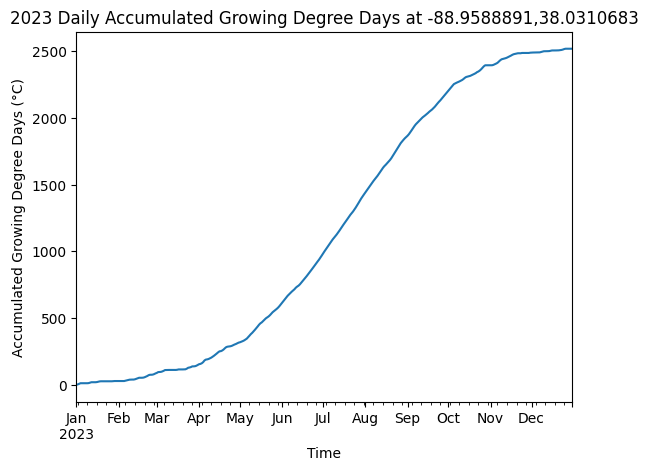

In [17]:
plot_var(df['acc_gdd'], f'2023 Daily Accumulated Growing Degree Days at {lon},{lat}', 'Accumulated Growing Degree Days (°C)')

In [18]:
client.close()

### Literature Cited
McMaster, G. S., & Wilhelm, W. W. (1997). Growing degree-days: one equation, two interpretations. Agricultural and forest meteorology, 87(4), 291-300.

# 